In [245]:
import numpy as np # fast math + arrays
import pandas as pd # read CSVs, data tables
import scipy.stats as st # probability models + .fit()
import matplotlib.pyplot as plt # plotting
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.special as sp
# ECDF: nonparametric cumulative curve
# --- OPTIONAL PLOT STYLE (makes plots cleaner; OK to skip) -----------------
plt.rcParams.update({
"axes.spines.top": False, # cleaner axes
"axes.spines.right": False,
"axes.grid": True, # light grid helps read values
"grid.alpha": 0.25,
})

In [246]:
def plot_ecdf(data, ax=None, **kw):
    """
    Make an ECDF step plot.
    WHY: shows all data points; no bins; great for comparing to model CDFs.
    """
    ec = ECDF(data) # compute ECDF object (x,y steps)
    ax = ax or plt.gca() # use passed axes OR current axes
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)") # F-hat = empirical CDF
    return ax

def aic(logL, k):
    """
    Compute Akaike Information Criterion.
    AIC = 2*k - 2*logL
    logL = maximized log-likelihood; k = # free parameters in model.
    Lower AIC -> better tradeoff fit vs complexity (same dataset only!).
    """
    return 2*k - 2*logL

def mean_from_params(dist_name, params):
    """
    Convert SciPy .fit() parameters -> model mean (in minutes).
    SciPy returns (shape[s], loc, scale) in this order for most continuous dists.
    NOTE: ’loc’ shifts the distribution; ’scale’ stretches it.
    """
    if dist_name == "gamma":
        a, loc, scale = params # a = shape (k)
        return loc + a*scale # Gamma mean = loc + k*theta
    elif dist_name == "weibull_min":
        c, loc, scale = params # c = shape
    # Weibull mean uses the gamma function:
        return loc + scale*sp.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params # s = sigma (log-scale SD); scale = exp(mu)
    # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan # unknown model

In [247]:
# --- LOAD DATA -------------------------------------------------------------
df = pd.read_csv("mbta_wait_times.csv") # expect columns: period, wait_min
# --- SPLIT INTO PRE / POST -------------------------------------------------
pre = df.loc[df.period=="PRE", "wait_min"].to_numpy()
post = df.loc[df.period=="POST", "wait_min"].to_numpy()
# --- QUICK SUMMARY ---------------------------------------------------------
print(f"PRE n={pre.size}, mean={pre.mean():.2f} min")
print(f"POST n={post.size}, mean={post.mean():.2f} min")

PRE n=600, mean=3.85 min
POST n=650, mean=4.84 min


### Q1

1. There are 600 records for pre construction, 650 for post
2. 3.85 min for PRE, 4.84 for POST

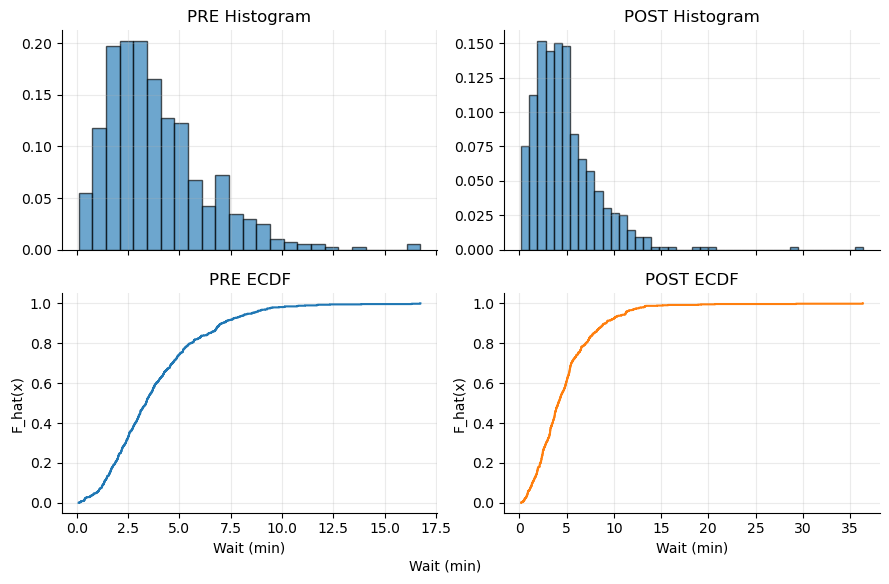

Outliers PRE: [np.float64(10.140301361924095), np.float64(12.329866645380712), np.float64(10.103327683786627), np.float64(9.450312777673624), np.float64(9.53380559359136), np.float64(10.779048035513943), np.float64(10.729393331843577), np.float64(11.696088188412755), np.float64(16.747253791076403), np.float64(13.875048039255976), np.float64(9.853289622499425), np.float64(11.739244918496466), np.float64(11.120463173855216), np.float64(9.422282193191313), np.float64(16.31647512129235)]
Outliers POST: [np.float64(13.371061233084175), np.float64(18.90672242169352), np.float64(13.287068768093212), np.float64(19.247471907444726), np.float64(20.70682148802069), np.float64(11.92570392589819), np.float64(12.392507216416744), np.float64(13.232650072889092), np.float64(12.86828829909019), np.float64(12.326314094483868), np.float64(13.151101395124812), np.float64(15.171682174238727), np.float64(29.27458640814392), np.float64(12.65177186074435), np.float64(12.667229050276362), np.float64(14.5597911

In [248]:
# --- 22 GRID: histograms (top) + ECDFs (bottom) --------------------------
fig, axs = plt.subplots(2, 2, figsize=(9,6), sharex='col')
# TOP ROW: HISTOGRAMS show approximate density
axs[0,0].hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,0].set_title("PRE Histogram")
axs[0,1].hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,1].set_title("POST Histogram")
# BOTTOM ROW: ECDFS show cumulative % of waits <= x
plot_ecdf(pre, ax=axs[1,0], color="C0"); axs[1,0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1,1], color="C1"); axs[1,1].set_title("POST ECDF")
fig.text(0.5,0.04,"Wait (min)", ha="center")
fig.tight_layout(rect=[0,0.04,1,1])
plt.show()

pre_iqr = np.quantile(pre, 0.75) - np.quantile(pre, 0.25)
pre_upper = np.quantile(pre, 0.75) + 1.5 * pre_iqr
pre_lower = np.quantile(pre, 0.25) - 1.5 * pre_iqr

pre_outliers = [num for num in pre if num < pre_lower or num > pre_upper]

post_iqr = np.quantile(post, 0.75) - np.quantile(post, 0.25)
post_upper = np.quantile(post, 0.75) + 1.5 * post_iqr
post_lower = np.quantile(post, 0.25) - 1.5 * post_iqr

post_outliers = [num for num in post if num < post_lower or num > post_upper]

print(f'Outliers PRE: {pre_outliers}')
print(f'Outliers POST: {post_outliers}')

### Q2

1. Between PRE and POST, PRE seems more spreadout but POST has more influential outliers
2. There are outliers in both PRE and POST, but POST is especially affected by an outlier at around 35

Candidate models: ['gamma', 'weibull_min', 'lognorm']


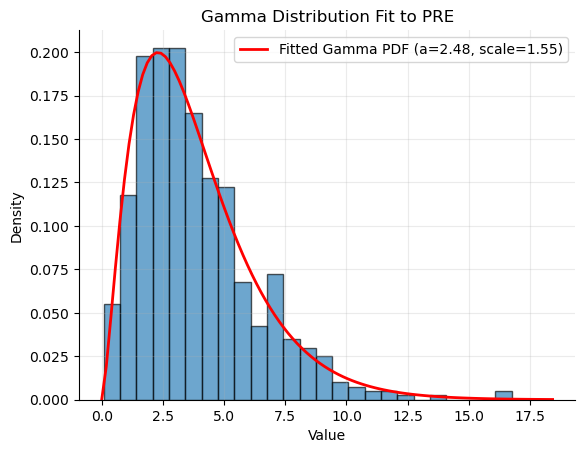

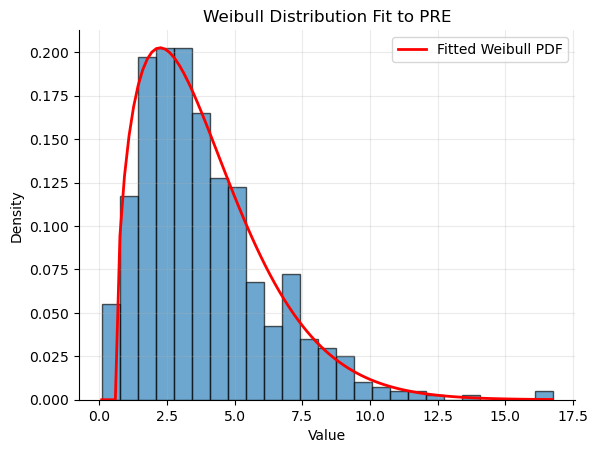

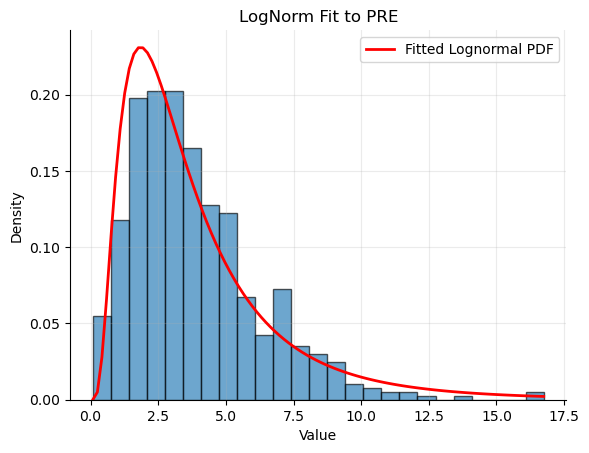

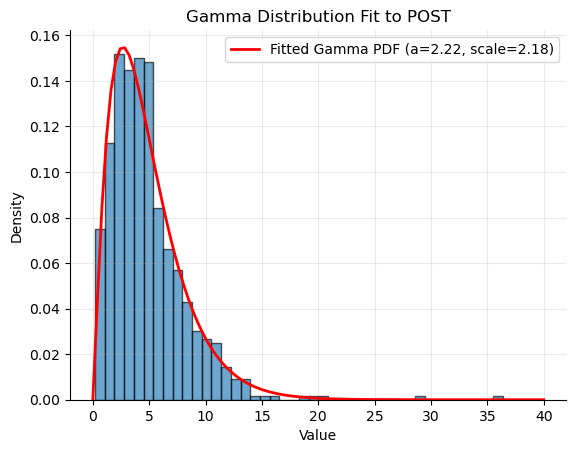

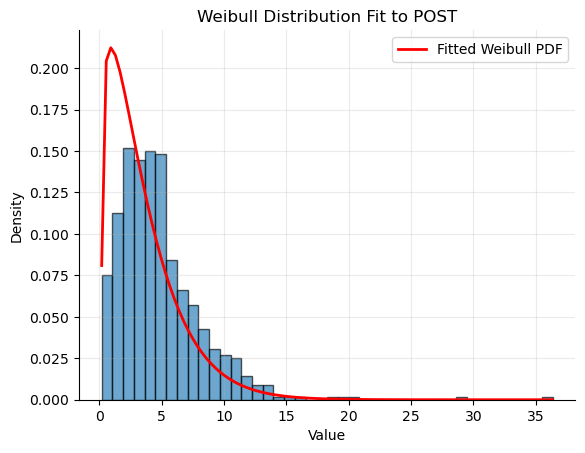

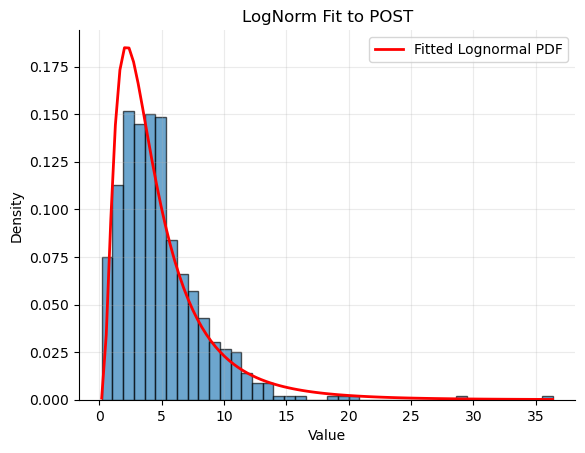

In [ ]:
# --- YOUR MODEL SHORTLIST --------------------------------------------------
candidates = {
    "gamma": st.gamma,
    "weibull_min": st.weibull_min,
    'lognorm':st.lognorm # swap/add "lognorm": st.lognorm if you like
}
print("Candidate models:", list(candidates))

plt.hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")

a_fit, loc_fit, scale_fit = st.gamma.fit(pre, floc=0) 

x = np.linspace(0, np.max(pre) * 1.1, 100) # Range for plotting PDF
pdf_fitted = st.gamma.pdf(x, a=a_fit, loc=loc_fit, scale=scale_fit)

plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Gamma PDF (a={a_fit:.2f}, scale={scale_fit:.2f})')

plt.title('Gamma Distribution Fit to PRE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

c_fit, loc_fit, scale_fit = st.weibull_min.fit(pre)

x = np.linspace(pre.min(), pre.max(), 100)
pdf_fitted = st.weibull_min.pdf(x, c_fit, loc_fit, scale_fit)

plt.hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Weibull PDF')
plt.title('Weibull Distribution Fit to PRE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

shape, loc, scale = st.lognorm.fit(pre, floc=0)

x = np.linspace(pre.min(), pre.max(), 100)
pdf_fitted = st.lognorm.pdf(x, shape, loc, scale)

plt.hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Lognormal PDF')
plt.title('LogNorm Fit to PRE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

plt.hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")

a_fit, loc_fit, scale_fit = st.gamma.fit(post, floc=0) 

x = np.linspace(0, np.max(post) * 1.1, 100) # Range for plotting PDF
pdf_fitted = st.gamma.pdf(x, a=a_fit, loc=loc_fit, scale=scale_fit)

plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Fitted Gamma PDF (a={a_fit:.2f}, scale={scale_fit:.2f})')

plt.title('Gamma Distribution Fit to POST')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

c_fit, loc_fit, scale_fit = st.weibull_min.fit(post)

x = np.linspace(post.min(), post.max(), 100)
pdf_fitted = st.weibull_min.pdf(x, c_fit, loc_fit, scale_fit)

plt.hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Weibull PDF')
plt.title('Weibull Distribution Fit to POST')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

shape, loc, scale = st.lognorm.fit(post, floc=0)

x = np.linspace(post.min(), post.max(), 100)
pdf_fitted = st.lognorm.pdf(x, shape, loc, scale)

plt.hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Lognormal PDF')
plt.title('LogNorm Fit to POST')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


### Q3:

1. Pick Gamma because it fits the criteria of our data the best
2. cannot have negative time so normal would not be great

In [250]:
def fit_models(data, models):
    """
    Fit each SciPy distribution in ‘models‘ to 1-D numpy array ‘data‘.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data) # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params) # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))
    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better
# --- FIT PRE & POST --------------------------------------------------------
fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

best_model_pre = fit_pre['AIC'].idxmin()
pre_min_row = fit_pre.loc[best_model_pre]

print(f'PRE Best Model: {best_model_pre}: (AIC = {pre_min_row['AIC']})')

best_model_post = fit_post['AIC'].idxmin()
post_min_row = fit_post.loc[best_model_post]

print(f'PRE Best Model: {best_model_post}: (AIC = {post_min_row['AIC']})')

fit_pre['AIC_change'] = fit_pre['AIC'] - pre_min_row['AIC']
fit_post['AIC_change'] = fit_post['AIC'] - post_min_row['AIC']

print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.45358379824501616, -1.2934360536889966, 4.6...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
lognorm,"(0.5360203743986013, -1.0685227608888868, 5.12...",-1578.630755,3,3163.261511
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


PRE Best Model: gamma: (AIC = 2600.9029271365584)
PRE Best Model: lognorm: (AIC = 3163.2615108919363)
PRE fits:


,params,logL,k,AIC,AIC_change
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927,0.0
lognorm,"(0.45358379824501616, -1.2934360536889966, 4.6...",-1298.316753,3,2602.633505,1.730578
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf,inf


POST fits:


,params,logL,k,AIC,AIC_change
lognorm,"(0.5360203743986013, -1.0685227608888868, 5.12...",-1578.630755,3,3163.261511,0.0
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653,0.391489
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013,150.507502


### Q4:

1. gamma has the lowest AIC value in PRE fits.
2. lognorm has the lowest AIC value in POST fits

### For PRE:
lognorm is essentially tied with gamma while weibull_min is way off

### For POST:
gamma is essentially tied with lognorm while weibull_min is way off

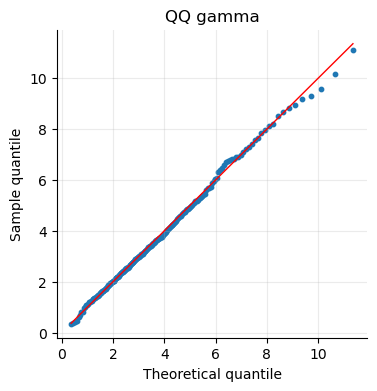

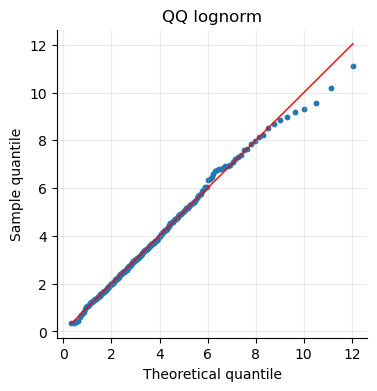

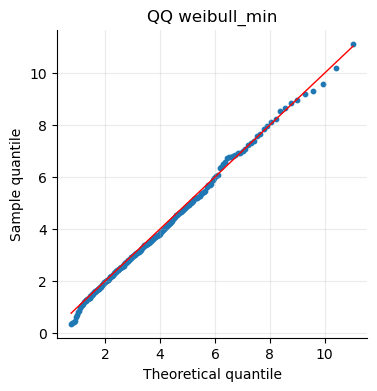

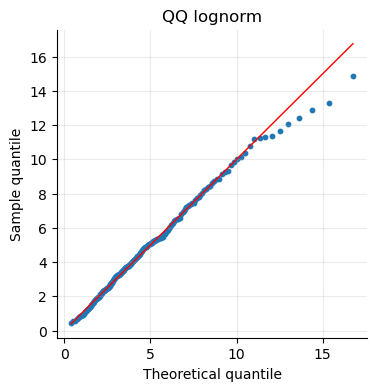

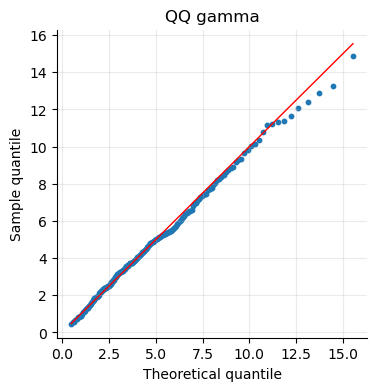

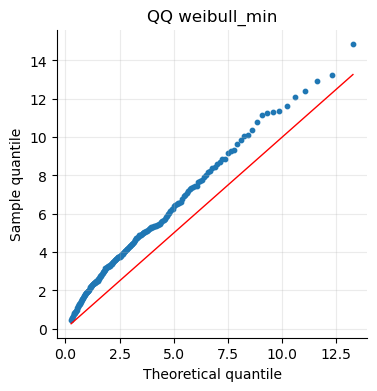

In [251]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):
    """
    Make QQ plots for each fitted model in fit_tbl.
    'probs' are the quantile levels (0-1) we compare.
    """
    qs = np.quantile(data, probs) # sample quantiles from data
    for name in fit_tbl.index: # models in AIC order
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params) # theoretical quantiles from model
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1) # 45 reference line
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

# --- MAKE QQ PLOTS ---------------------------------------------------------
qq_compare(pre, fit_pre, candidates)
qq_compare(post, fit_post, candidates)

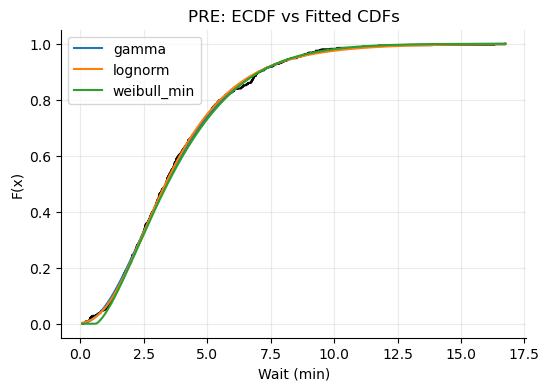

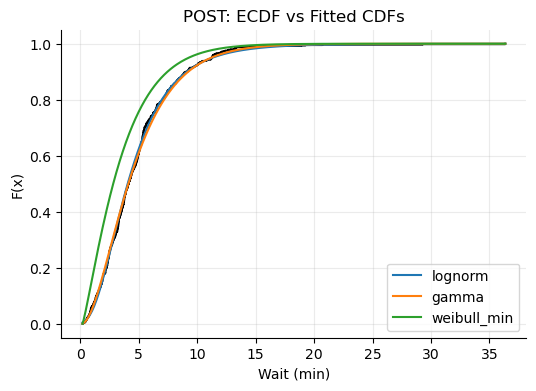

In [252]:
def cdf_overlay(data, fit_tbl, models, title):
    """
    ECDF (black steps) + each fitted model’s CDF (smooth lines).
    """
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
# --- MAKE CDF OVERLAYS -----------------------------------------------------
cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

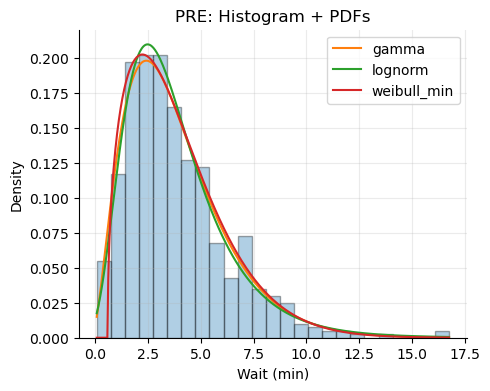

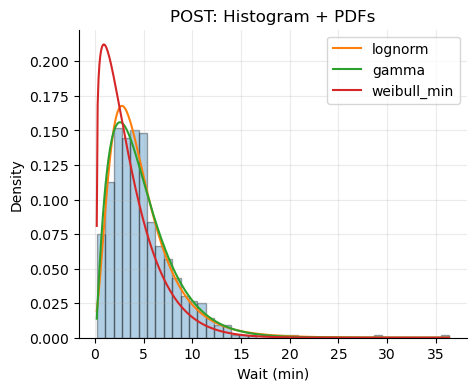

In [253]:
def pdf_overlay(data, fit_tbl, models, title):
    """
    Histogram (density=True) + PDFs from each fitted model.
    """
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("Density")
# --- MAKE PDF OVERLAYS -----------------------------------------------------
pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")

### Q5

1. Models struggle most in the upper tail of the POST distribution
2. Outliers in both models do stretch the curve especially on weibull

In [254]:
# --- PICK BEST MODELS BY AIC -----------------------
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

Best PRE model: gamma mean3.85 min
Best POST model: lognorm mean4.84 min
Change POST-PRE: +0.99 min (1.26)


1. After construction, typical waits are about .99 minutes longer
2. Not really
3. Yes because more models that fit skew indicate the same thing


PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.45358379824501616, -1.2934360536889966, 4.6...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
gamma,"(2.3460100404546056, 0.00195002568524905, 2.01...",-1545.321472,3,3096.642944
lognorm,"(0.4851349823760922, -1.4203669384353848, 5.47...",-1550.638898,3,3107.277796
weibull_min,"(1.4708828795926325, 0.36878643299760944, 4.82...",-inf,3,inf


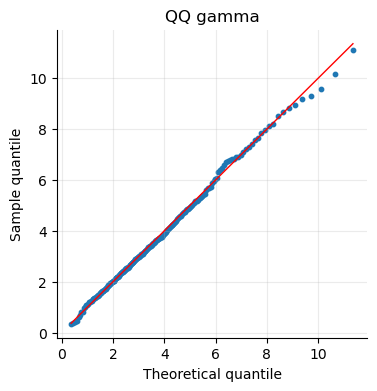

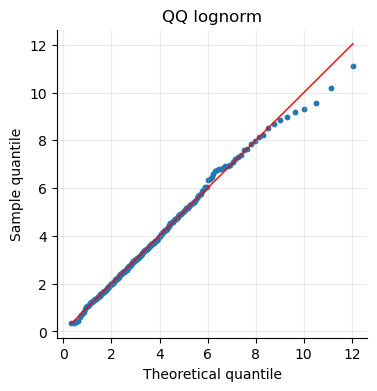

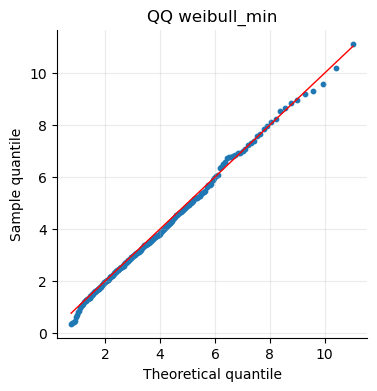

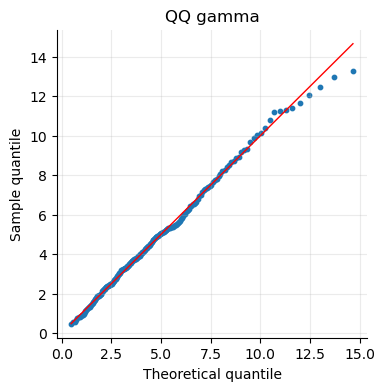

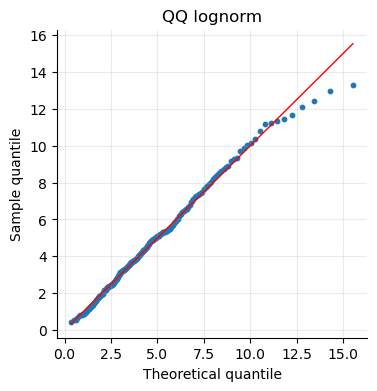

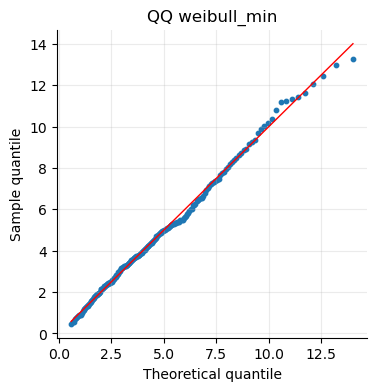

Best PRE model: gamma mean3.85 min
Best POST model: gamma mean4.73 min
Change POST-PRE: +0.88 min (1.23)


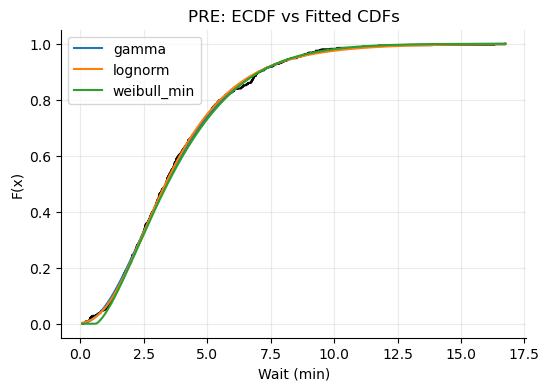

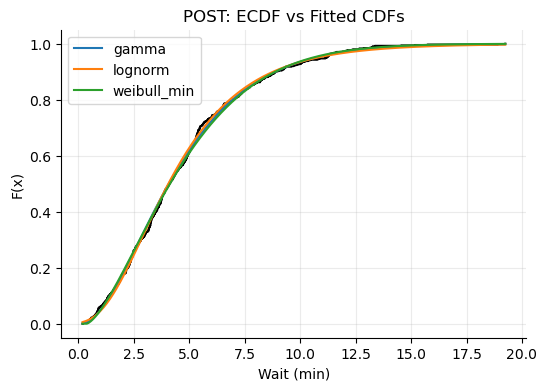

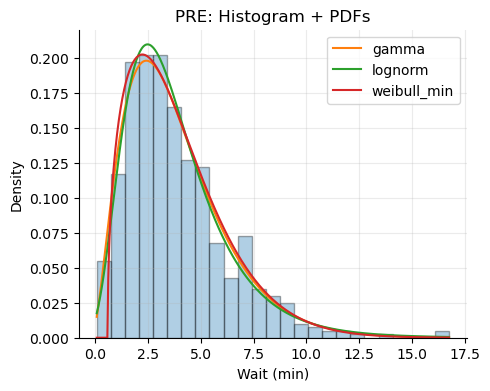

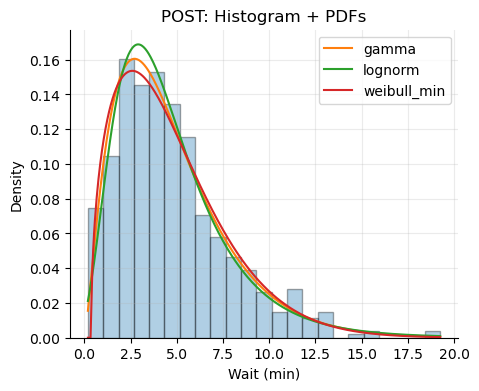

In [255]:
trim_pre = np.array([x for x in pre if x <= 20])
trim_post = np.array([x for x in post if x <= 20])

fit_pre_trim = fit_models(trim_pre, candidates)
fit_post_trim = fit_models(trim_post, candidates)
print("PRE fits:"); display(fit_pre_trim)
print("POST fits:"); display(fit_post_trim)

qq_compare(trim_pre, fit_pre_trim, candidates)
qq_compare(trim_post, fit_post_trim, candidates)

cdf_overlay(trim_pre, fit_pre_trim, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(trim_post, fit_post_trim, candidates, title="POST: ECDF vs Fitted CDFs")

pdf_overlay(trim_pre, fit_pre_trim, candidates, "PRE: Histogram + PDFs")
pdf_overlay(trim_post, fit_post_trim, candidates, "POST: Histogram + PDFs")

# --- PICK BEST MODELS BY AIC -----------------------
best_pre = fit_pre_trim.index[0]
best_post = fit_post_trim.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre_trim.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post_trim.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.45358379824501616, -1.2934360536889966, 4.6...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
gamma,"(2.2118368746170463, 0.048167833830613224, 2.1...",-1568.0624,3,3142.1248
weibull_min,"(1.5052528341624938, 0.171571264938014, 5.1377...",-1570.489572,3,3146.979145
lognorm,"(0.5133755051392661, -1.2240013101801506, 5.29...",-1571.888359,3,3149.776718


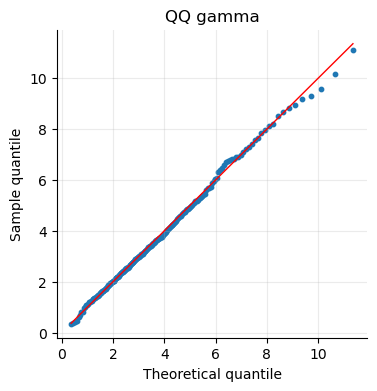

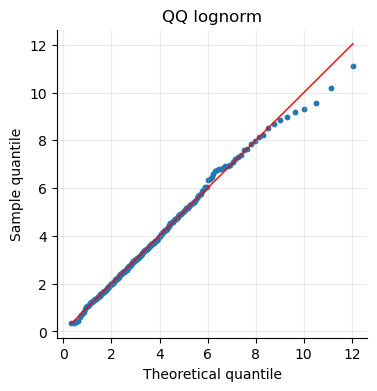

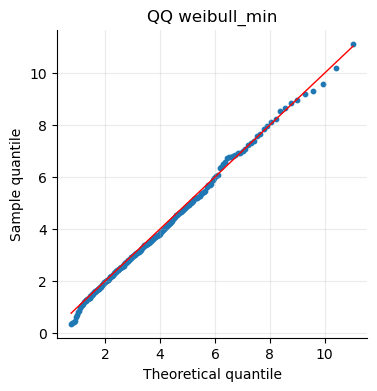

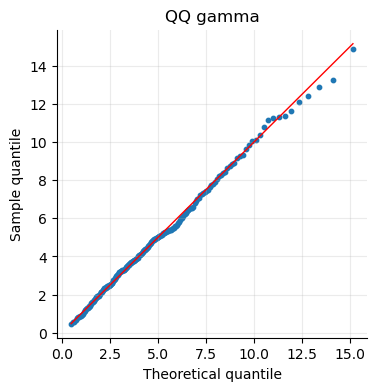

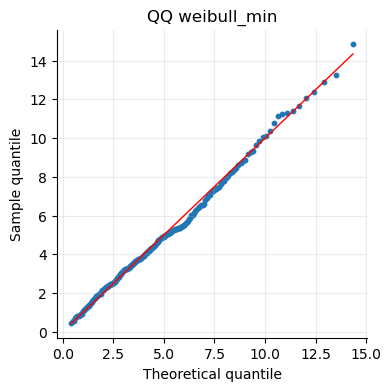

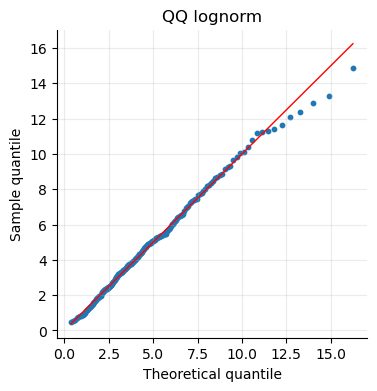

Best PRE model: gamma mean3.85 min
Best POST model: gamma mean4.80 min
Change POST-PRE: +0.95 min (1.25)


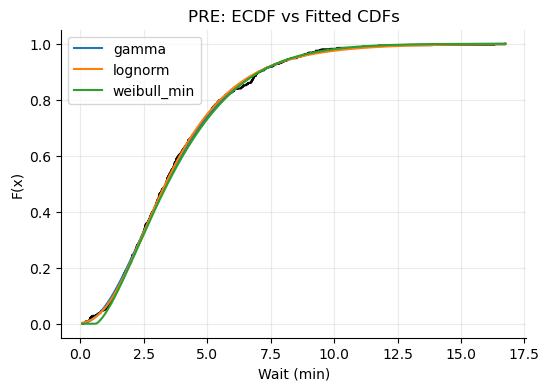

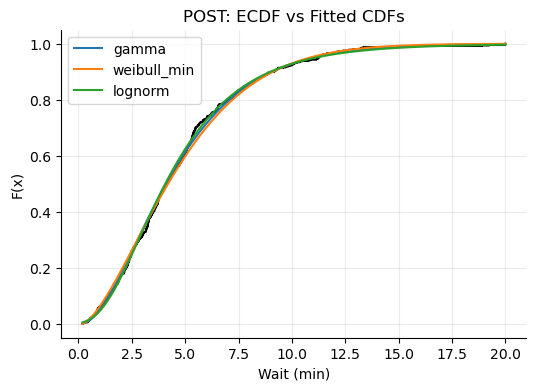

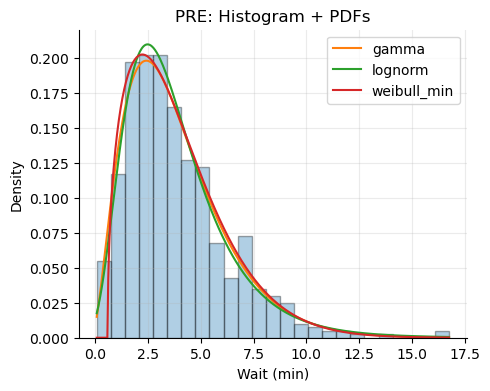

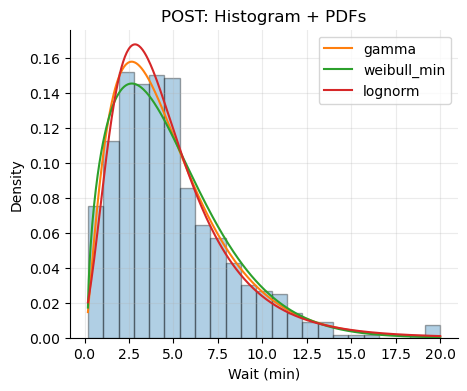

In [256]:
trim_pre = np.array([min(x, 20) for x in pre])
trim_post = np.array([min(x, 20) for x in post])

fit_pre_trim = fit_models(trim_pre, candidates)
fit_post_trim = fit_models(trim_post, candidates)
print("PRE fits:"); display(fit_pre_trim)
print("POST fits:"); display(fit_post_trim)

qq_compare(trim_pre, fit_pre_trim, candidates)
qq_compare(trim_post, fit_post_trim, candidates)

cdf_overlay(trim_pre, fit_pre_trim, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(trim_post, fit_post_trim, candidates, title="POST: ECDF vs Fitted CDFs")

pdf_overlay(trim_pre, fit_pre_trim, candidates, "PRE: Histogram + PDFs")
pdf_overlay(trim_post, fit_post_trim, candidates, "POST: Histogram + PDFs")

# --- PICK BEST MODELS BY AIC -----------------------
best_pre = fit_pre_trim.index[0]
best_post = fit_post_trim.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre_trim.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post_trim.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

The mean difference was lowered when we exclude all outliers. If we convert all outliers to 20 the difference also decreases but by less